In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [6]:
file_path = Path("/Users/macbook/Documents/Projects_portfolio/blood-supply-risk-monitor/data/silver/toronto_collisions/toronto_collisions_silver.csv").resolve()
df = pd.read_csv(file_path)

In [10]:
df['clean_date'] = pd.to_datetime(df['clean_date'])

# Extract time features
df['Year'] = df['clean_date'].dt.year
df['Month'] = df['clean_date'].dt.month_name()
df['Hour'] = df['OCC_HOUR']
df['DayOfWeek'] = df['clean_date'].dt.day_name()

# Set categorical ordering for correct plotting
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=days_order, ordered=True)
df['Month'] = pd.Categorical(df['Month'], categories=months_order, ordered=True)

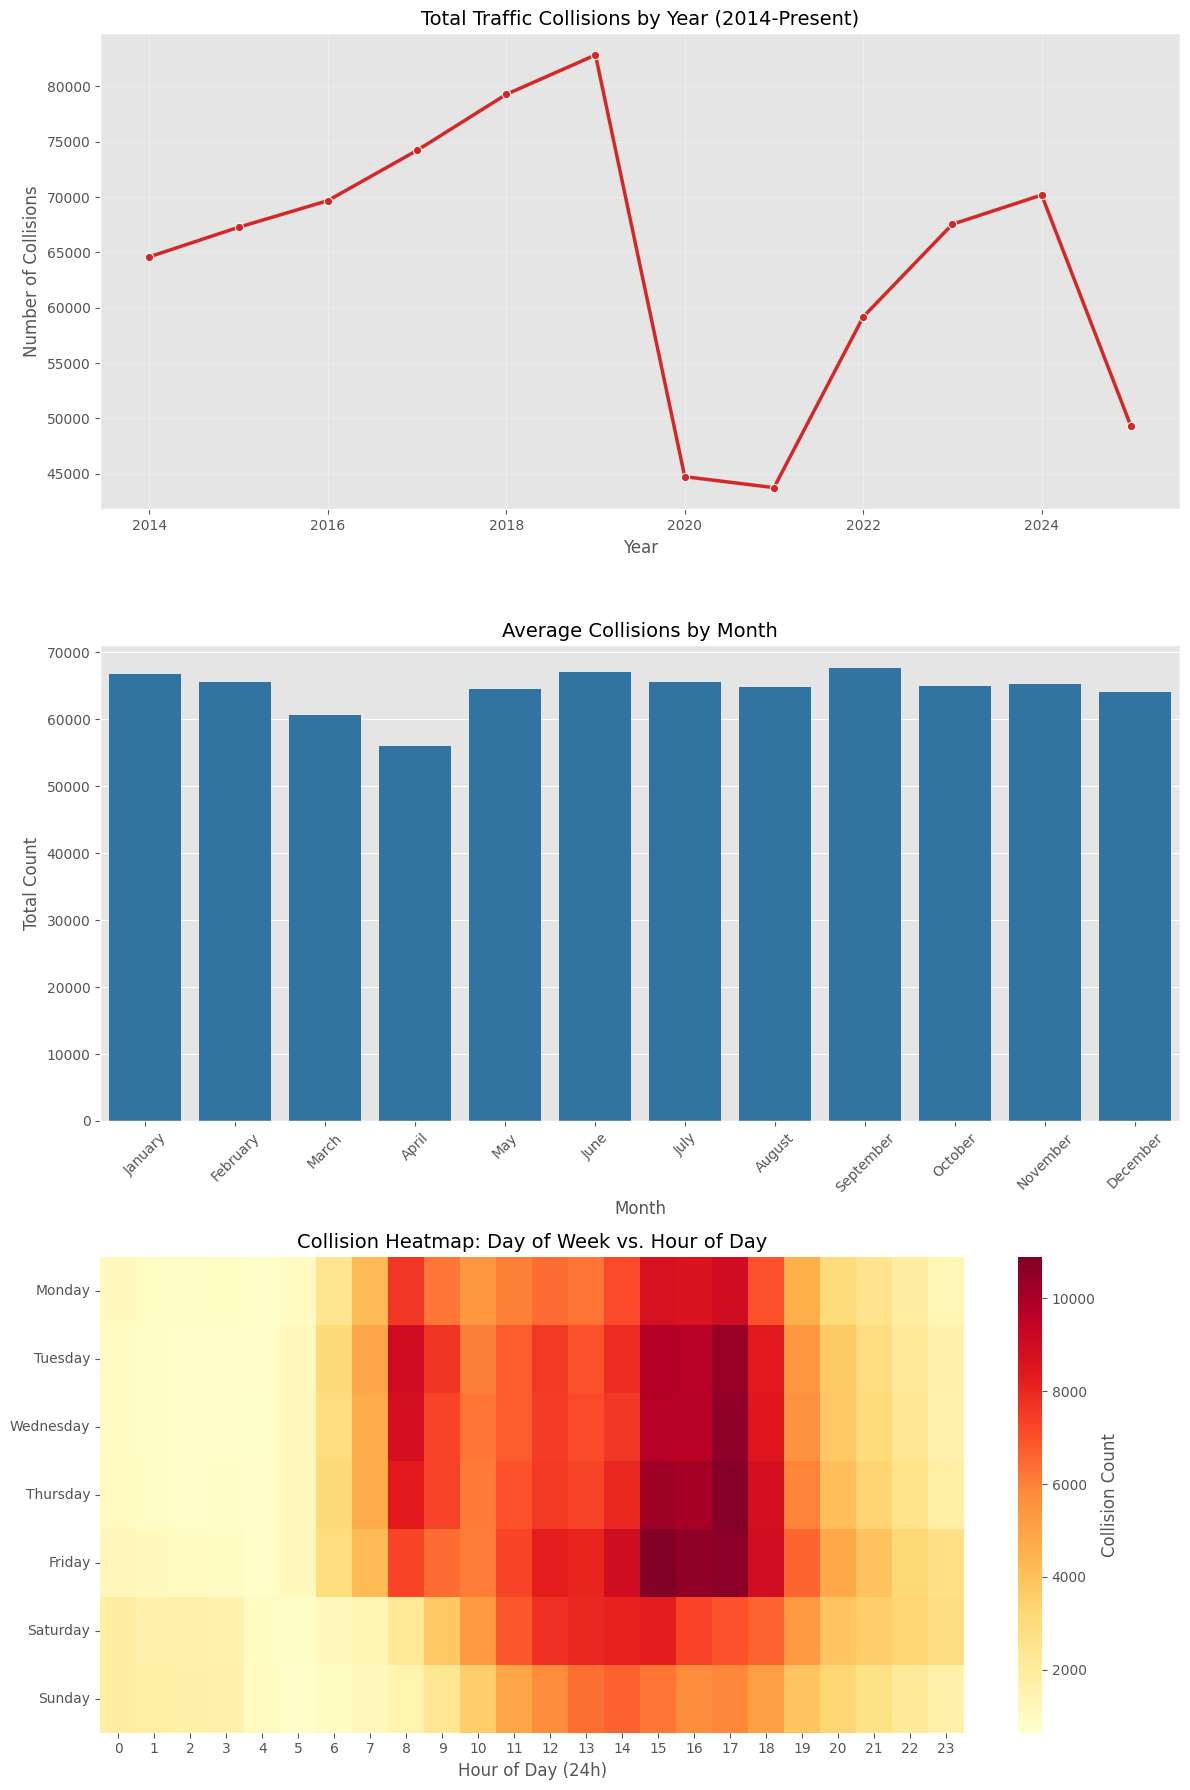

In [11]:
# %%
# Set plot style
plt.style.use('ggplot')
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 1. Yearly Trend
yearly_counts = df.groupby('Year').size()
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o', ax=axes[0], color='#d62728', linewidth=2.5)
axes[0].set_title('Total Traffic Collisions by Year (2014-Present)', fontsize=14)
axes[0].set_ylabel('Number of Collisions')
axes[0].grid(True, alpha=0.3)

# 2. Monthly Seasonality
monthly_counts = df.groupby('Month', observed=True).size()
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=axes[1], color='#1f77b4')
axes[1].set_title('Average Collisions by Month', fontsize=14)
axes[1].set_ylabel('Total Count')
axes[1].tick_params(axis='x', rotation=45)

# 3. Weekly/Hourly Heatmap
pivot_table = df.pivot_table(index='DayOfWeek', columns='Hour', values='EVENT_UNIQUE_ID', aggfunc='count', observed=True)
sns.heatmap(pivot_table, cmap='YlOrRd', ax=axes[2], cbar_kws={'label': 'Collision Count'})
axes[2].set_title('Collision Heatmap: Day of Week vs. Hour of Day', fontsize=14)
axes[2].set_xlabel('Hour of Day (24h)')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

/var/folders/97/k138wd455js8lymmwb7spx900000gn/T/ipykernel_3961/485591075.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Count', y='Type', data=inv_df, palette='viridis')


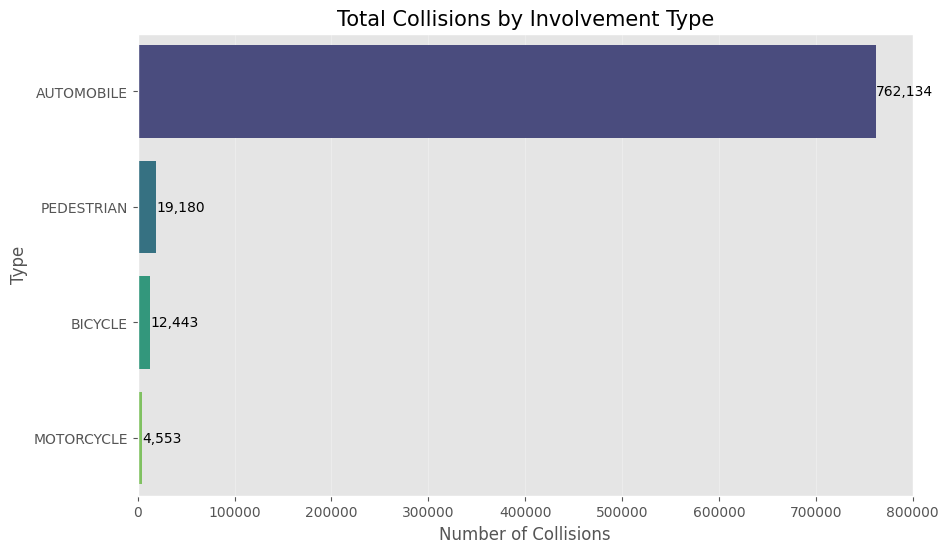

In [12]:
# %%
# Define columns to analyze
involvement_cols = ['AUTOMOBILE', 'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'TRUCK']

# Calculate counts of "YES" for each type
counts = {}
for col in involvement_cols:
    if col in df.columns:
        counts[col] = df[col].astype(str).str.upper().eq('YES').sum()

# Convert to DataFrame for plotting
inv_df = pd.DataFrame(list(counts.items()), columns=['Type', 'Count']).sort_values('Count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Count', y='Type', data=inv_df, palette='viridis')

# Add labels to the end of bars
for i, v in enumerate(inv_df['Count']):
    barplot.text(v + 500, i, f'{v:,}', va='center')

plt.title('Total Collisions by Involvement Type', fontsize=15)
plt.xlabel('Number of Collisions')
plt.grid(axis='x', alpha=0.3)
plt.show()

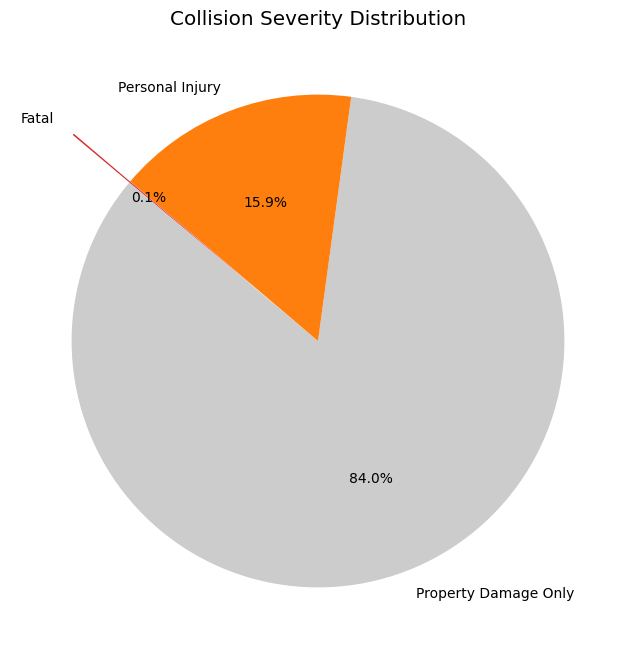

Severity Counts:
  Property Damage Only: 552,210
  Personal Injury: 104,840
  Fatal: 664


In [14]:

severity_counts = {
    'Property Damage Only': df['PD_COLLISIONS'].eq('YES').sum(),
    'Personal Injury': df['INJURY_COLLISIONS'].eq('YES').sum(),
    'Fatal': df['FATALITIES'].sum() # Fatalities is a number count, not a flag
}


plt.figure(figsize=(8, 8))
plt.pie(severity_counts.values(), labels=severity_counts.keys(), autopct='%1.1f%%', 
        colors=['#cccccc', '#ff7f0e', '#d62728'], startangle=140, explode=(0, 0, 0.3))
plt.title('Collision Severity Distribution')
plt.show()

print("Severity Counts:")
for k, v in severity_counts.items():
    print(f"  {k}: {v:,}")

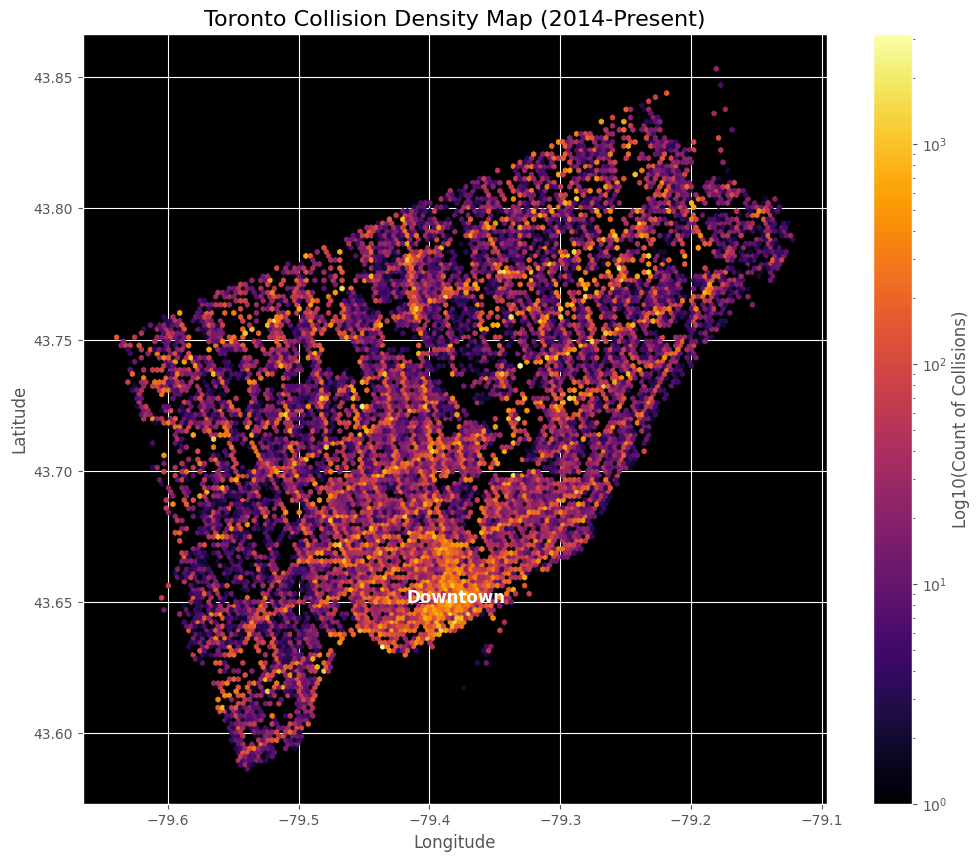

In [ ]:

geo_df = df[(df['LAT_WGS84'] != 0) & (df['LONG_WGS84'] != 0)].dropna(subset=['LAT_WGS84', 'LONG_WGS84'])

plt.figure(figsize=(12, 10))

# 2. Create the Hexbin
# 'gridsize' controls the resolution (higher = smaller hexagons)
# 'cmap' = 'inferno' makes hotspots glow nicely against a dark background
hb = plt.hexbin(
    geo_df['LONG_WGS84'], 
    geo_df['LAT_WGS84'], 
    gridsize=150, 
    cmap='inferno', 
    mincnt=1,  # Only show hexagons with at least 1 accident
    bins='log' # Use logarithmic scale because hotspots are HUGE compared to side streets
)

# 3. Styling
cb = plt.colorbar(hb, label='Log10(Count of Collisions)')
plt.title('Toronto Collision Density Map (2014-Present)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Annotate the "Downtown Core" roughly (Visual estimation based on Toronto coords)
plt.text(-79.38, 43.65, 'Downtown', color='white', fontsize=12, ha='center', fontweight='bold')

plt.gca().set_facecolor('black') # Black background makes the map pop
plt.show()

/var/folders/97/k138wd455js8lymmwb7spx900000gn/T/ipykernel_3961/1304852594.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Injury Rate (%)', y='Mode', data=stats_df, palette='Reds_r')


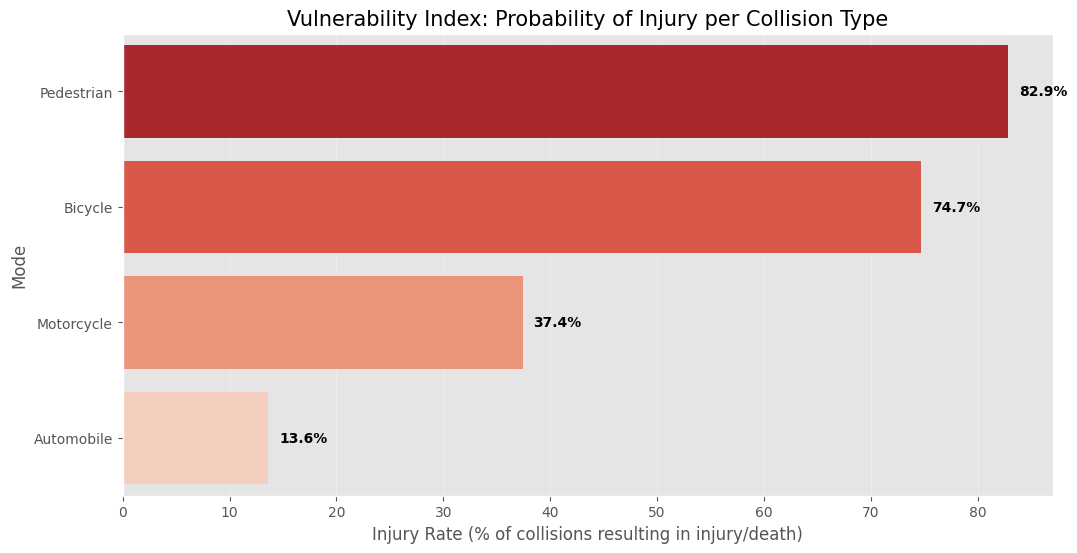

In [16]:

modes = ['AUTOMOBILE', 'PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE', 'TRUCK']
stats = []

for mode in modes:
    if mode in df.columns:
        # Filter for collisions involving this mode
        subset = df[df[mode] == 'YES']
        total = len(subset)
        
        # Calculate Injury+Fatal Count
        # We consider a collision "Dangerous" if it has Injury=YES or Fatalities > 0
        dangerous = subset[
            (subset['INJURY_COLLISIONS'] == 'YES') | 
            (subset['FATALITIES'] > 0)
        ]
        danger_count = len(dangerous)
        
        # Calculate Percentage
        rate = (danger_count / total) * 100 if total > 0 else 0
        
        stats.append({
            'Mode': mode.title(), 
            'Total Collisions': total,
            'Injury Rate (%)': rate
        })

stats_df = pd.DataFrame(stats).sort_values('Injury Rate (%)', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Injury Rate (%)', y='Mode', data=stats_df, palette='Reds_r')

# Add percentage labels
for i, v in enumerate(stats_df['Injury Rate (%)']):
    plt.text(v + 1, i, f"{v:.1f}%", va='center', fontweight='bold')

plt.title('Vulnerability Index: Probability of Injury per Collision Type', fontsize=15)
plt.xlabel('Injury Rate (% of collisions resulting in injury/death)')
plt.grid(axis='x', alpha=0.3)
plt.show()

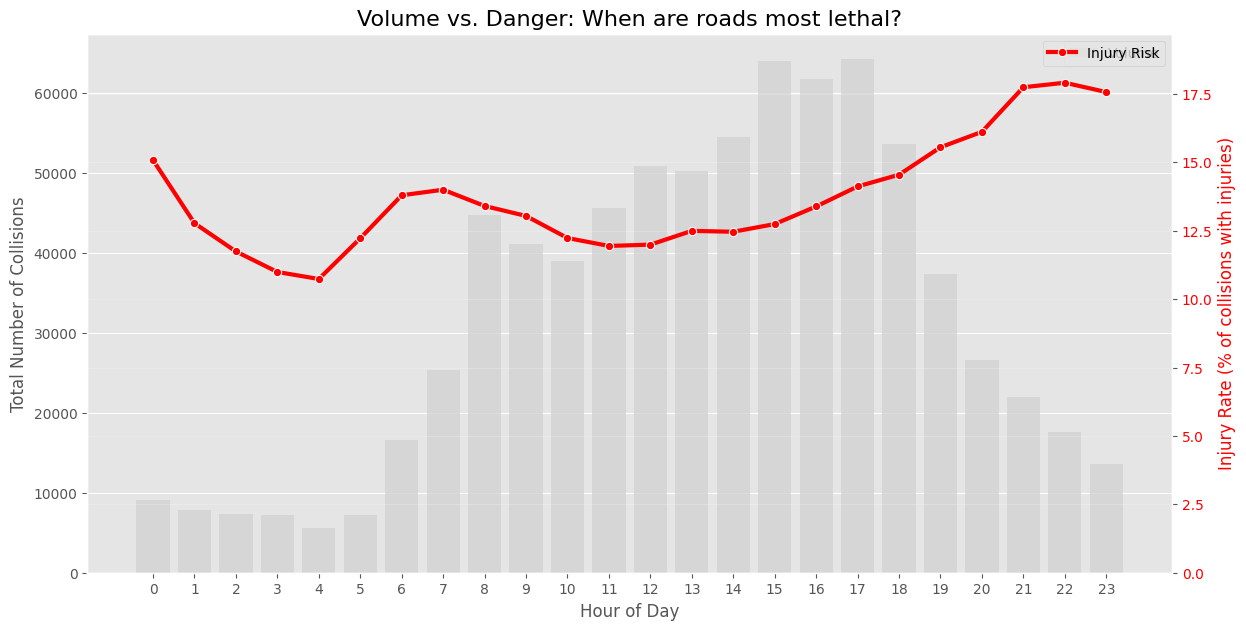

In [17]:
# Group by Hour
hourly_stats = df.groupby('Hour').agg(
    Total_Count=('EVENT_UNIQUE_ID', 'count'),
    # Calculate Sum of Fatalities + Injury Flags
    Injury_Count=('INJURY_COLLISIONS', lambda x: x.eq('YES').sum())
).reset_index()

# Calculate Risk Percentage
hourly_stats['Injury_Rate'] = (hourly_stats['Injury_Count'] / hourly_stats['Total_Count']) * 100

# Plotting - Dual Axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Axis 1: Total Volume (Bar)
sns.barplot(x='Hour', y='Total_Count', data=hourly_stats, ax=ax1, color='lightgray', alpha=0.8, label='Volume')
ax1.set_ylabel('Total Number of Collisions', fontsize=12)
ax1.set_xlabel('Hour of Day', fontsize=12)

# Axis 2: Risk Line (Line)
ax2 = ax1.twinx()
sns.lineplot(x='Hour', y='Injury_Rate', data=hourly_stats, ax=ax2, color='red', marker='o', linewidth=3, label='Injury Risk')
ax2.set_ylabel('Injury Rate (% of collisions with injuries)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(hourly_stats['Injury_Rate']) * 1.1)

plt.title('Volume vs. Danger: When are roads most lethal?', fontsize=16)
plt.grid(True, alpha=0.2)
plt.show()